<a href="https://colab.research.google.com/github/kkahe/hello-world/blob/main/GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [ ]:
latent_dim = 100


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()


        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:

                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers


        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [ ]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )


    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

In [ ]:
train_set = torchvision.datasets.EMNIST(
    root = './data/EMNIST',
    split = 'letters',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor() 
    ])
)
test_set = torchvision.datasets.EMNIST(
    root = './data/EMNIST',
    split = 'letters',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor() 
    ])
)
dataloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/EMNIST/raw/gzip.zip to ./data/EMNIST/EMNIST/raw


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:

generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
import time

n_epochs = 100 
sample_interval = 1000 
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) 
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) 

        real_imgs = imgs.cuda()

        optimizer_G.zero_grad()

        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        generated_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/100] [D loss: 0.539456] [G loss: 1.728328] [Elapsed time: 29.09s]
[Epoch 1/100] [D loss: 0.397891] [G loss: 1.251898] [Elapsed time: 58.05s]
[Epoch 2/100] [D loss: 0.441103] [G loss: 1.680293] [Elapsed time: 88.09s]
[Epoch 3/100] [D loss: 0.357997] [G loss: 1.424243] [Elapsed time: 117.25s]
[Epoch 4/100] [D loss: 0.357721] [G loss: 1.698322] [Elapsed time: 146.50s]
[Epoch 5/100] [D loss: 0.375135] [G loss: 1.758095] [Elapsed time: 175.95s]
[Epoch 6/100] [D loss: 0.327702] [G loss: 1.237350] [Elapsed time: 204.51s]
[Epoch 7/100] [D loss: 0.355840] [G loss: 1.884586] [Elapsed time: 233.29s]
[Epoch 8/100] [D loss: 0.349261] [G loss: 1.812810] [Elapsed time: 262.37s]
[Epoch 9/100] [D loss: 0.261384] [G loss: 2.106219] [Elapsed time: 291.47s]
[Epoch 10/100] [D loss: 0.291145] [G loss: 1.877792] [Elapsed time: 320.04s]
[Epoch 11/100] [D loss: 0.353790] [G loss: 1.433911] [Elapsed time: 348.78s]
[Epoch 12/100] [D loss: 0.254517] [G loss: 2.118132] [Elapsed time: 377.73s]
[Epoch 13/10

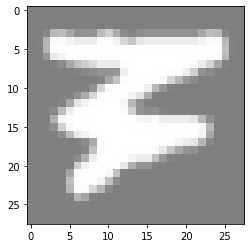

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_set))
imshow_grid(example_mini_batch_img)